In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

In [2]:
groq_api_key  = os.getenv("GROQ_API_KEY")

## langsmith Tracing
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Chatbot With Messages Summarization"

In [3]:
llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [4]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

In [22]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

## calling node of conversion
def call_model(state: State):
    # Get summary if exists
    summary = state.get("summary", "")
    
    # if summary is exists
    if summary:
        system_messages = f"Summary of the earlier conversion: {summary}"
        
        # add summary with the system messages
        messages = [SystemMessage(content=system_messages)] + state["messages"]
        
    else:
        messages = state['messages']
        
    response = llm.invoke(messages)
    
    return {
        'messages': response
    }

## Now define the node who can produce the summary and and trim the messages

In [6]:
def summarize_conversation(state: State):
    # first extract the exists summary if exists
    
    summary = state.get("summary", "")
    
    if summary:
        # a summary already exists
        summary_messages = (
            f"This is summary of the  conversation to data: {summary}\n\n"
            "Extend the summary by taking into acount the new messages above"
        )
        
    else:
        summary_messages = "Create a summary of the conversation above"
        
    ## add prompt to the history
    messages = state["messages"] + [HumanMessage(content=summary_messages)]
    response = llm.invoke(messages)
    
    ## Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id = m.id) for m in state["messages"][: -2]]
    return {
        'summary': response,
        'messages': delete_messages
    }

#### **Now add the conditional edge to determine weather to produce a summary based on the conversion length**

In [7]:
from langgraph.graph import END
# determine weather to end or summarize the conversation
def should_continue(state: State):
    """return the next node to execute."""
    
    messages = state['messages']
    
    if len(messages) > 6:
        return "summarize_conversation"
    
    # otherwise just return the END
    return END

## ***Adding memory***

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

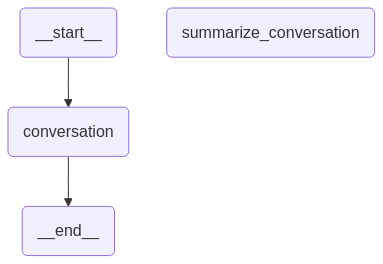

In [23]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [24]:
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="Assalamualikum! I'm Alamin")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Wa alaikumussalam! Nice to meet you, Alamin! How are you today?
================================== Ai Message ==================================

Your name is Alamin!
================================== Ai Message ==================================

A fan of the San Francisco 49ers, huh? Which player is your favorite?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [25]:
graph.get_state(config).values.get("summary","")

''

In [26]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nick Bosa is an incredible player! As of 2022, he signed a 5-year, $170 million contract extension with the 49ers, which makes him one of the highest-paid defensive players in the NFL. He's definitely a key player for the 49ers' defense! Do you think they'll make a deep run in the playoffs this season?


In [27]:
graph.get_state(config).values.get("summary","")

AIMessage(content="Here is a summary of our conversation:\n\n* You introduced yourself as Alamin and I responded with a greeting.\n* You mentioned that you like the San Francisco 49ers.\n* You expressed your admiration for Nick Bosa and asked if he's the highest-paid defensive player.\n* I confirmed that Nick Bosa is indeed one of the highest-paid defensive players in the NFL.\n\nLet me know if you'd like to chat more about the 49ers or anything else!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 202, 'total_tokens': 297, 'completion_time': 0.18644245, 'prompt_time': 0.007354814, 'queue_time': 0.048670286, 'total_time': 0.193797264}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd88ee34-7c0d-4026-8757-34d297b56cd1-0', usage_metadata={'input_tokens': 202, 'output_tokens': 95, 'total_tokens': 297})